# **Sesión 3: Procesamiento Avanzado de Imágenes** ⚙️🖼️

## **Instalaciones**

In [1]:
!pip install tqdm scikit-learn openpyxl pandas matplotlib

## **Librerías**

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from bow import BoW
from dataset import Dataset
from image_classifier import ImageClassifier
import time
from tqdm import tqdm
import sys
import pickle
import os

# **Apartado C**: Detección de puntos de interés y Bolsa de palabras

## **C1: Detección de puntos de interés**

### **Tarea C.1.1**: Generar función de filtro gaussiano

Se generará a partir de la imagen base las imágenes con el filtrado gaussiano. Para ello se empleará la función `generateGaussianImages()` que tiene que desarrollar empleando la función [`cv2.GaussianBlur()`](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#gae8bdcd9154ed5ca3cbc1766d960f45c1). Es recomendble visualizar los resultados para comprobar el funcionamiento. Para ello convierta los datos de la imagen a visualizar a `np.uint8`

In [2]:
def generateGaussianImages(image, sigmas):
    """Generate the gaussian images using the base image and the sigmas given

    Args:
        image (np.array[np.float32]): Base image to blur
        sigmas (List[np.float32]): Sigmas for blurring the image 

    Returns:
        List[np.array[np.float32]: List of blurred images
    """
    gaussian_images = []

    # TODO: Generate the list of blurred images using cv2.GaussianBlur()
    for sigma in sigmas:
        image = cv2.GaussianBlur(image, (5, 5), sigma)
        gaussian_images.append(image)
    
    return gaussian_images
    

### **Tarea C.1.2**: Generación de espacio de escalas con imágenes gaussianas

Empleando la función anterior, complete la siguiente celda para generar las imágenes gaussianas

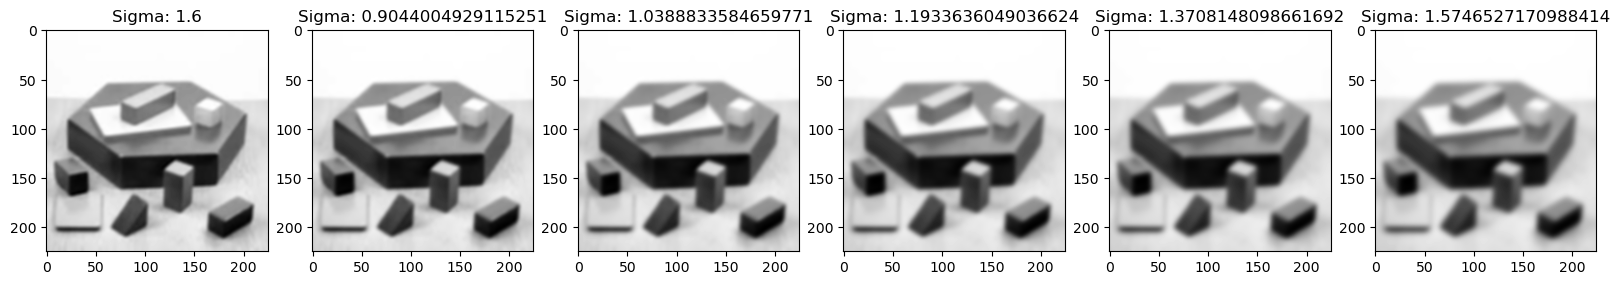

In [3]:
#TODO: Load the image in grayscale
source_path = "../data/source"
image = cv2.imread(os.path.join(source_path, "0.jpg"), cv2.IMREAD_GRAYSCALE)
image = image.astype(np.float32)
# Number of diference of gaussians to generate (minimum 3)
# TODO: Adjust this number to make sure keypoints are generated
intervals = 5
# Initial sigma
sigma = 1.6 
# We get the necessary sigmas from the given method generateGaussianSigmas()
sigmas = generateGaussianSigmas(sigma, intervals)
#TODO: Generate the gaussian images
gaussian_images = generateGaussianImages(image, sigmas)

# Show the images
plt.figure(figsize=(20, 20))
for i, img in enumerate(gaussian_images):
	plt.subplot(1, len(gaussian_images), i+1)
	plt.imshow(img, cmap='gray')
	plt.title(f"Sigma: {sigmas[i]}")

### **Tarea C.1.3**: Generación de diferencias de gaussianas

Utilizando la lista de imágenes gaussianas se generará una lista con las diferencias entre pares consegutivos. Para ello se empleará la función `generateDoGImages()` que tiene que desarrollar empleando la función [`cv2.subtract()`](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#gaa0f00d98b4b5edeaeb7b8333b2de353b)

In [4]:
def generateDoGImages(gaussian_images):
	"""Generate Difference-of-Gaussians list

	Args:
		gaussian_images (List[np.array[np.float32]): List of blurred images

	Returns:
		List[np.array[np.float32]: List of difference of gaussian images
	"""
	dog_images = []

    # TODO: Generate the list of difference of gaussians using cv2.subtract()
	for i in range(1, len(gaussian_images)):
		dog_img = cv2.subtract(gaussian_images[i], gaussian_images[i-1])
		dog_images.append(dog_img) 
    
	return dog_images

dog_images = generateDoGImages(gaussian_images)

# Show the images
for img in dog_images:
	cv2.imshow("DoG", img)
	cv2.waitKey(0)
	cv2.destroyAllWindows()

### **Tarea C.1.4**: Evaluación de extremos

La función `isPixelAnExtremum()` debe evaluar si el pixel central del bloque compuesto por las regiones de las 3 imágenes es un máximo o mínimo entre ellos. Como prevención, tenga en cuenta que puede tomar valores positivos y negativos

In [67]:
def isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
	"""Return True if the center element of the 3x3x3 array composed of subimages is strictly greater than or less than all its neighbors, False otherwise

	Args:
		first_subimage (np.array): Patch from first gaussian
		second_subimage (np.array): Patch from second gaussian
		third_subimage (np.array): Patch from third gaussian
		threshold (float): Value threshold for the pixel

	Returns:
		Bool: True if maximum or minimum, False otherwise
	"""
	extremum = False
    # TODO: Check if the center pixel value is a maximum or a minimum and if its absolute value is higher than the threshold
	center = second_subimage[1, 1]
	if center > 0:
		extremum = (abs(center) > threshold) and (center >= np.max(first_subimage)) and (center >= np.max(third_subimage))
	else:
		extremum = (abs(center) > threshold) and (center <= np.min(first_subimage)) and (center <= np.min(third_subimage))

	return extremum

In [33]:
first_subimage = np.zeros((3,3),np.float32)
third_subimage = np.zeros((3,3),np.float32)
second_subimage = np.ones((3,3),np.float32)
isPixelAnExtremum(first_subimage,second_subimage, third_subimage, 0.03)

True

### **Tarea C.1.5**: Localización de puntos clave y orientación de los mismos

La función `findScaleSpaceExtrema()` obtendrá los puntos clave y su orientación a partir de las gaussianas y sus diferencias empleando, entre otras, la función `isPixelAnExtremum()`. Deberá completar las partes indicadas para recorrer todos los trios de imágenes consecutivos y evaluar los píxeles necesarios de estos.

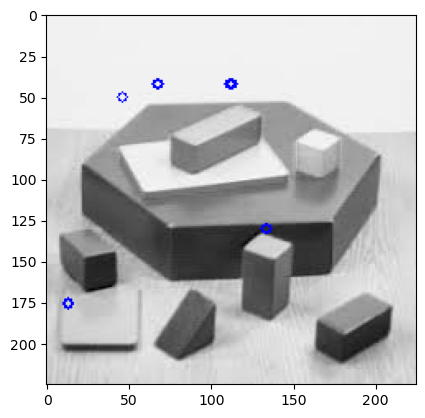

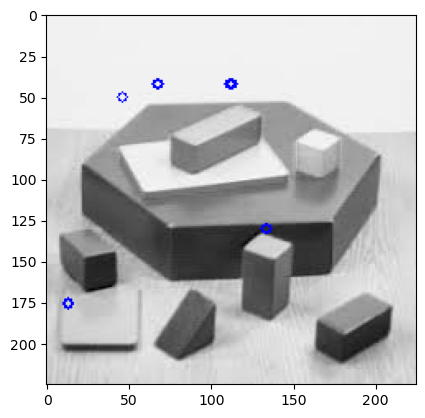

In [ ]:
def findScaleSpaceExtrema(gaussian_images, dog_images, num_intervals, sigma, threshold=0.03):
    """Find pixel positions of all scale-space extrema in the image pyramid """
    keypoints = []

    # Create triplets for as many positions as possible
    zipped_dog_images = [
        (dog_images[i], dog_images[i + 1], dog_images[i + 2])
        for i in range(len(dog_images) - 2)
    ]

    # TODO: Fill the loop source data
    for image_index, (first_image, second_image, third_image) in enumerate(zipped_dog_images):
        # (i, j) is the center of the 3x3 array
        # TODO: Fill the 2 range limits knowing you have to move the 3x3 window across the whole image
        for i in range(1, len(second_image) - 1):
            for j in range(1, len(second_image[0]) - 1):
                # TODO: Fill the method with the required arguments
                first_subimage = first_image[i-1:i+2, j-1:j+2]
                second_subimage = second_image[i-1:i+2, j-1:j+2]
                third_subimage = third_image[i-1:i+2, j-1:j+2]

                if isPixelAnExtremum(first_subimage, second_subimage, third_subimage, threshold):
                    # Refine the keypoint localization
                    localization_result = localizeExtremumViaQuadraticFit(i, j, image_index + 1, num_intervals, dog_images, sigma)
                    # keypoint = cv2.KeyPoint()
                    # keypoint.pt = (j, i)
                    # keypoint.size = sigma * 2**(image_index)
                    # keypoint.response = abs(second_subimage[1, 1])
                    # keypoints.append(keypoint)

                    localization_result = (keypoint, image_index)

                    if localization_result is not None:
                        keypoint, localized_image_index = localization_result
                        # Get the keypoint orientation
                        keypoints_with_orientations = computeKeypointsWithOrientations(keypoint, gaussian_images[localized_image_index])
                        for keypoint_with_orientation in keypoints_with_orientations:
                            keypoints.append(keypoint_with_orientation)
    return keypoints

# Keypoint Detection with Taylor Expansion and Contrast Thresholding
threshold = 0.00005
keypoints = findScaleSpaceExtrema(gaussian_images, dog_images, intervals, sigma, threshold)
visualizeKp(image, keypoints)
keypoints = removeDuplicateKeypoints(keypoints)
visualizeKp(image, keypoints)

Con los puntos clave totalmente definidos y las imágenes gaussianas ya podemos obtener los descriptores con la función proporcionada de `generateDescriptors()`

In [66]:
descriptors = generateDescriptors(keypoints, gaussian_images)

### **Tarea C.1.6**: Pipeline de generación de puntos clave y descriptores

Complete la función con los métodos desarrollados en tareas previas para generar los puntos clave y descriptores necesarios dada una imagen, un valor de sigma y un número de diferencias de gaussianas

In [9]:
def computeKeypointsAndDescriptors(image, sigma=1.6, num_intervals=3):
    """Compute SIFT keypoints and descriptors for an input image """
    # TODO: Fill the pipeline to get the keypoint and descriptors as before
    image = image.astype('float32')
    gaussian_kernels = None
    gaussian_images = None
    dog_images = None
    keypoints = None
    descriptors = None
    return keypoints, descriptors

### **Tarea C.1.7**: Correspondencia de características entre imágenes

Cargue las imágenes con `cv2` y complete la llamada a la función previa

In [ ]:
# TODO: Load the images with cv2 in grayscale
img1 = None
img2 = None

# TODO: Fill the function calls
kp1, des1 = computeKeypointsAndDescriptors()
kp2, des2 = computeKeypointsAndDescriptors()

matchFeatures(img1, kp1, des1, img2, kp2, des2)

#### **Ampliación**: SIFT con OpenCV

In [ ]:
# Load the image
image_0 = cv2.imread('../data/0.jpg', cv2.IMREAD_GRAYSCALE)
image_1 = cv2.imread('../data/0_rot.jpg', cv2.IMREAD_GRAYSCALE)

# Create a SIFT detector object
sift = cv2.SIFT_create()

# Detect keypoints and compute descriptors
keypoints_0, descriptors_0 = sift.detectAndCompute(image_0, None)
keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)

# Draw keypoints on the image
image_with_keypoints_0 = cv2.drawKeypoints(image_0, keypoints_0, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
image_with_keypoints_1 = cv2.drawKeypoints(image_1, keypoints_1, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(image_with_keypoints_0)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()
plt.imshow(image_with_keypoints_1)
plt.title('Keypoints with Blob Sizes and Orientations')
plt.axis('off')
plt.show()

# Initialize BFMatcher
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)

# Perform KNN matching with k=2 for ratio test
matches = bf.match(descriptors_0, descriptors_1)

# sort matches by distance
matches = sorted(matches, key = lambda x:x.distance)


# Draw the good matches
matched_image = cv2.drawMatches(image_0, keypoints_0, image_1, keypoints_1, matches[:50], None,
                                flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(matched_image)
plt.title("Feature Matches")
plt.axis('off')
plt.show()

### **Pregunta C1**: Correspodencia de imágenes propias y evaluación

In [ ]:
# TODO: Homework

## **C2: Bolsa de palabras**

### **Tarea C.2.1**: Carga de los datasets de entrenamiento y validación para la bolsa de palabras

Empleando el método `load()` de la clase [`Dataset`](.\dataset.py) que se le proporciona, cargue los datasets de entrenamiento y validación.

In [ ]:
training_set = Dataset.load()
validation_set = Dataset.load()

### **Tarea C.2.2**: Extracción de los descriptores

Para poder crear la bolsa de palabras se va a comenzar obteniendo los descriptores que serán agrupados en las distintas palabras de nuestra bolsa. Para ello complete la carga de la imagen en la ruta `path` en escala de grises y obtenga sus descriptores con los métodos apropiados de cv2. Los descriptores obtenidos se añadirán a nuestra bolsa de palabras (`words`) para después ser agrupados por palabras que representen

In [ ]:
feature_extractor = cv2.SIFT_create()

# Extract features
print("\nComputing SIFT descriptors...")
time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
descriptors = []
for path in tqdm(training_set, unit="image", file=sys.stdout):
    # TODO: Load the image from the path in grayscale
    image = cv2.imread()
    try:
        # TODO: Using the cv2 methods get the descriptors for the image
        _, descriptor = None
    except:
        print(f"WARN: Issue generating descriptor for image {path}")

    if descriptor is not None:
        descriptors.append(descriptor)

### **Tarea C.2.3**: Creación del vocabulario

Añada los descriptores a la bolsa (`words`) con el método add de la misma. Con los descriptores en la bolsa, se va a realizar el agrupamiento de los mismos por palabras para obtener un vocabulario de palabras visuales. Complete la ruta de apertura del archivo y establezca el modo de apertura en escrituria y bineario para poder guardar el vocabulario generado.

In [ ]:
# Build vocabulary
vocabulary_size = 100
iterations = 20
termination_criteria = (cv2.TERM_CRITERIA_MAX_ITER | cv2.TERM_CRITERIA_EPS, iterations, 1e-6)
words = cv2.BOWKMeansTrainer(vocabulary_size, termination_criteria)

# TODO: Add all descriptors
words.add()

time.sleep(0.1)  # Prevents a race condition between tqdm and print statements.
print("\nClustering descriptors into", vocabulary_size, "words using K-means...")
vocabulary = words.cluster()
filename=  "vocabulary.pickle"
# TODO: Open the file from above in the write and binay mode
with open() as f:
    pickle.dump(["SIFT", vocabulary], f, pickle.HIGHEST_PROTOCOL)

### **Tarea C.2.4**: Entrenamiento del clasificador

Una vez se tiene el vocabulario de palabras visuales, se va a entrenar al classificador. Para ello haga uso de la clase [BoW](./bow.py) y complete los métodos que se le indican

In [ ]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary()

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the training method
image_classifier.train()
classifier = "classifier"
image_classifier.save(classifier)

### **Tarea C.2.5**: Inferencia en dataset de entrenamiento
Con el modelo entrenado se procede a comprobar su desempeño con el dataset de entrenamiento. Complete los métodos indicados

In [ ]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary()

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load()
# TODO: Especify the args for the loading method
image_classifier.predict()

### **Tarea C.2.6**: Inferencia en dataset de evaluación

A continuación se evalua el desempeño del modelo con el dataset de validación. Complete los métodos indicados

In [ ]:
bow = BoW()
# TODO: Especify the args for the loading method
bow.load_vocabulary()

image_classifier = ImageClassifier(bow)
# TODO: Especify the args for the loading method
image_classifier.load()
# TODO: Especify the args for the loading method
image_classifier.predict()

### **Pregunta C.2.A**: Cambio de SIFT por Kaze

In [ ]:
#TODO: Homework

### **Pregunta C.2.B**: ¿Cuántas palabras uso?

In [ ]:
#TODO: Homework

### **EXTRA - Pregunta C.2.C**: Buscando los mejóres parámetros

In [ ]:
#TODO: Homework